In [2]:
# Line magics
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# import modules
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from fastai import *
from fastai.vision import *
from pathlib import Path
import pretrainedmodels

import torchvision
from utils import *

In [4]:
def lr_find():
    learn.lr_find()
    learn.recorder.plot()

In [5]:
def confusion_matrix(figsize=(7,7)):
    preds,y,losses = learn.get_preds(with_loss=True)
    interp = ClassificationInterpretation(learn, preds, y, losses)
    interp.plot_confusion_matrix(figsize=figsize)
    

In [6]:
path = Path('../data')
train_path = f'{path}/train/'


In [7]:
print(os.listdir('../data'))

['test', '.ipynb_checkpoints', 'train']


In [8]:
fnames = get_image_files(train_path+'A')
fnames[:5]

[PosixPath('../data/train/A/A1766.jpg'),
 PosixPath('../data/train/A/A1523.jpg'),
 PosixPath('../data/train/A/A1753.jpg'),
 PosixPath('../data/train/A/A1019.jpg'),
 PosixPath('../data/train/A/A1682.jpg')]

torch.Size([3, 200, 200])


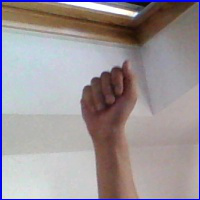

In [9]:
img = open_image(fnames[0])
print(img.shape)
img

In [10]:
# set batch size
bs=64
np.random.seed(99)
sz = 64

In [11]:
def get_data(sz = 200,bs=32):
    tfms = get_transforms(flip_vert = False, max_zoom = 0.7)
    data = ImageDataBunch.from_folder(path,train='train', valid_pct = 0.2, ds_tfms=tfms, bs=bs, size=sz)
    data.normalize(imagenet_stats)
    return data

In [12]:
data = get_data(sz = int(64*1.3), bs =64)

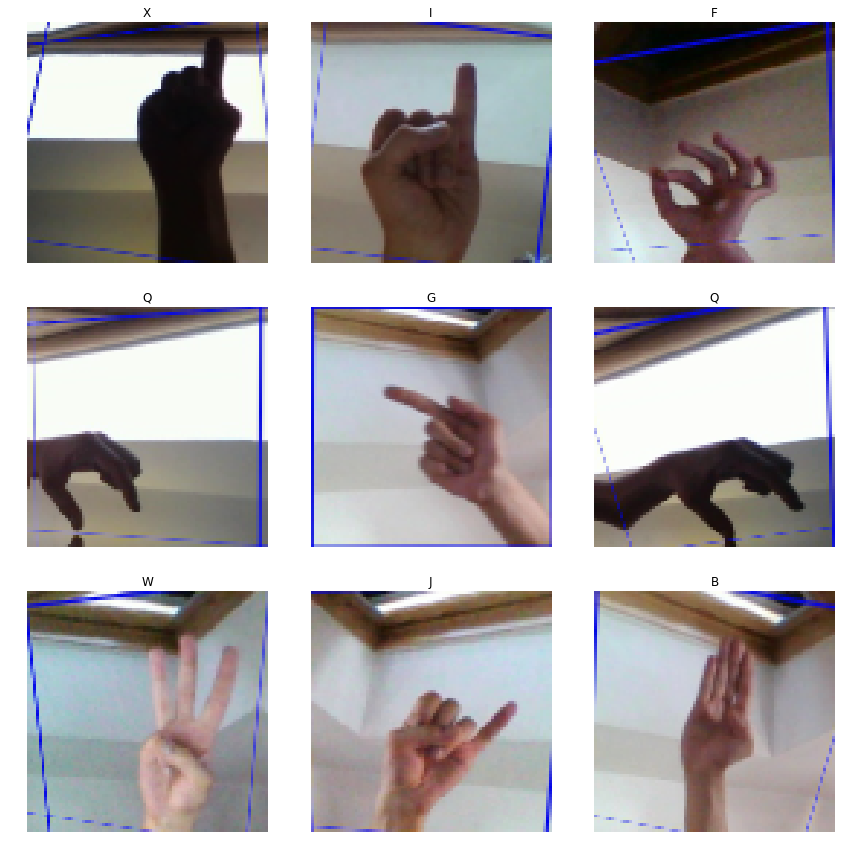

In [13]:
data.show_batch(3)

In [14]:
data.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space',
 'test']

In [15]:
pd.DataFrame({'models':pretrainedmodels.model_names})

,models
0,fbresnet152
1,bninception
2,resnext101_32x4d
3,resnext101_64x4d
4,inceptionv4
5,inceptionresnetv2
6,alexnet
7,densenet121
8,densenet169
9,densenet201


In [16]:
def resnext50(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

In [17]:
arch_summary(resnext50)

(0) Conv2d      : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) ReLU        : 1   layers (total: 3)
(3) MaxPool2d   : 1   layers (total: 4)
(4) Sequential  : 38  layers (total: 42)
(5) Sequential  : 50  layers (total: 92)
(6) Sequential  : 74  layers (total: 166)
(7) Sequential  : 38  layers (total: 204)
(8) AvgPool2d   : 1   layers (total: 205)
(9) Linear      : 1   layers (total: 206)


In [18]:
metrics = [accuracy]
learn = create_cnn(data, resnext50, pretrained=False,metrics = metrics,
                   cut=-2, split_on=lambda m: (m[0][5], m[1]),model_dir='../models/')

In [ ]:
lr_find()

In [ ]:
learn.freeze()
learn.fit_one_cycle(5, max_lr = slice(1e-03, 1e-01))

In [ ]:
learn.unfreeze()
lr_find()

In [ ]:
learn.fit_one_cycle(10,max_lr = slice(1e-06,2e-04))

In [ ]:
confusion_matrix((10,10))

In [ ]:
learn.save('asl_resnext50_64')

In [18]:
learn.load('asl_resnext50_64')

Learner(data=ImageDataBunch;

Train: LabelList (69623 items)
x: ImageItemList
Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83)
y: CategoryList
test,test,test,test,test
Path: ../data;

Valid: LabelList (17405 items)
x: ImageItemList
Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83)
y: CategoryList
B,R,N,O,S
Path: ../data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, ke

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05


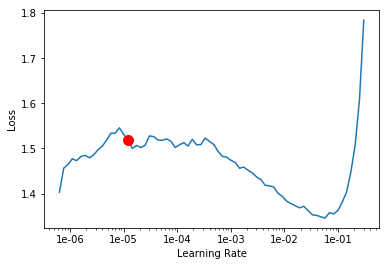

In [19]:
learn.freeze()
learn.data = get_data(sz=128,bs =64)
lr_find()

In [20]:
learn.fit_one_cycle(4,max_lr = slice(1e-02))

epoch,train_loss,valid_loss,accuracy
1,0.602366,0.262279,0.921230
2,0.417354,0.565115,0.950187
3,0.316843,0.101866,0.977190
4,0.259190,0.074246,0.984602


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


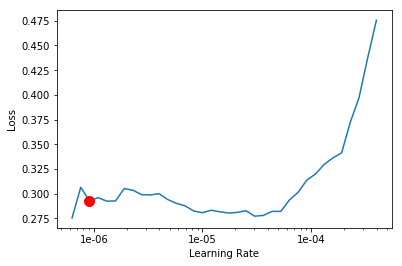

In [21]:
learn.unfreeze()
lr_find()

In [22]:
learn.fit_one_cycle(10,max_lr = slice(1e-06,2e-04))

epoch,train_loss,valid_loss,accuracy
1,0.262690,0.068382,0.983396
2,0.237310,0.121815,0.983798
3,0.185592,0.041431,0.991554
4,0.164414,0.048374,0.995001
5,0.124388,0.043221,0.992761
6,0.094041,0.030535,0.997300
7,0.079002,0.016193,0.997817
8,0.068989,0.011553,0.998736
9,0.059303,0.012132,0.998908
10,0.065777,0.014884,0.999138


In [23]:
learn.save('asl_resnext50_128')

In [19]:
learn.load('asl_resnext50_128')

Learner(data=ImageDataBunch;

Train: LabelList (69623 items)
x: ImageItemList
Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83)
y: CategoryList
test,test,test,test,test
Path: ../data;

Valid: LabelList (17405 items)
x: ImageItemList
Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83),Image (3, 83, 83)
y: CategoryList
B,R,N,O,S
Path: ../data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, ke

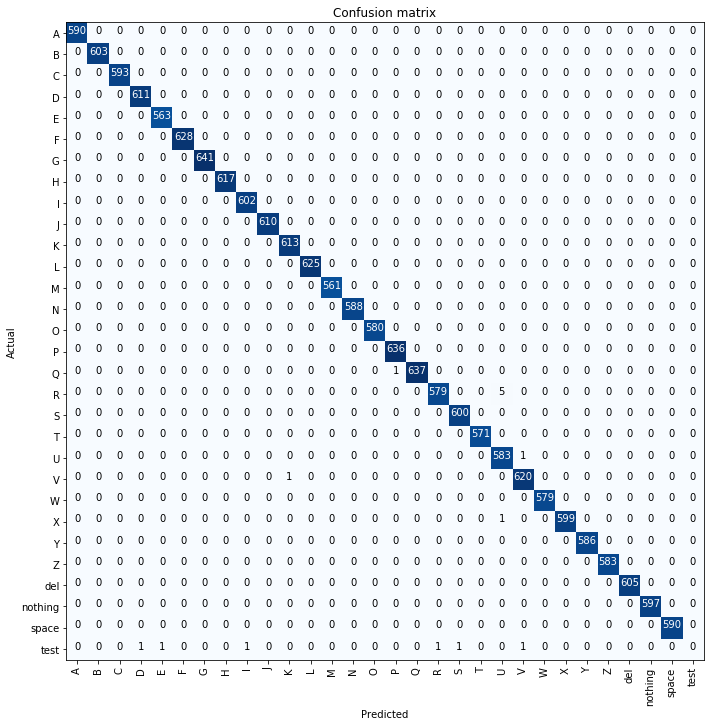

In [26]:
confusion_matrix((10,10))

In [20]:
learn.data = get_data(sz=200)

In [21]:
learn.freeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


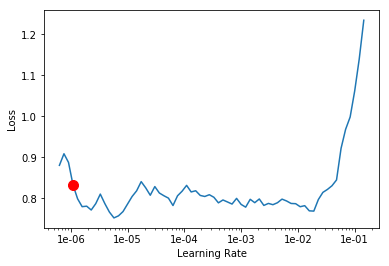

In [22]:
lr_find()

In [23]:
learn.fit_one_cycle(4,max_lr = slice(1e-04,2e-02))

epoch,train_loss,valid_loss,accuracy
1,0.410235,0.229829,0.969721
2,0.340581,0.728251,0.978684
3,0.137453,2.505955,0.993737
4,0.080689,0.083455,0.996380


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


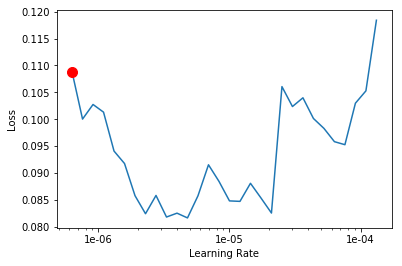

In [24]:
learn.unfreeze()
lr_find()

In [25]:
learn.fit_one_cycle(4,max_lr = slice(1e-06,2e-04))

epoch,train_loss,valid_loss,accuracy
1,0.091920,0.559046,0.993450
2,0.076664,0.033698,0.994140
3,0.056014,0.487692,0.995519
4,0.031768,0.064597,0.997472


In [26]:
learn.fit_one_cycle(10,max_lr = slice(1e-06,2e-04))

epoch,train_loss,valid_loss,accuracy
1,0.040860,0.008705,0.999138
2,0.062219,0.111592,0.996553
3,0.052523,0.709596,0.997127
4,0.051968,0.453679,0.994772
5,0.040967,0.008830,0.998736
6,0.042856,1.251546,0.995921
7,0.015886,0.610020,0.997127
8,0.027145,0.007094,0.999540
9,0.011794,0.027273,0.999081
10,0.013929,0.005344,0.999598


In [27]:
learn.save('asl_resnext50_250')

In [29]:
learn.load('asl_resnext50_250')

Learner(data=ImageDataBunch;

Train: LabelList (69623 items)
x: ImageItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
test,test,test,test,test
Path: ../data;

Valid: LabelList (17405 items)
x: ImageItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
E,J,Y,T,T
Path: ../data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2):

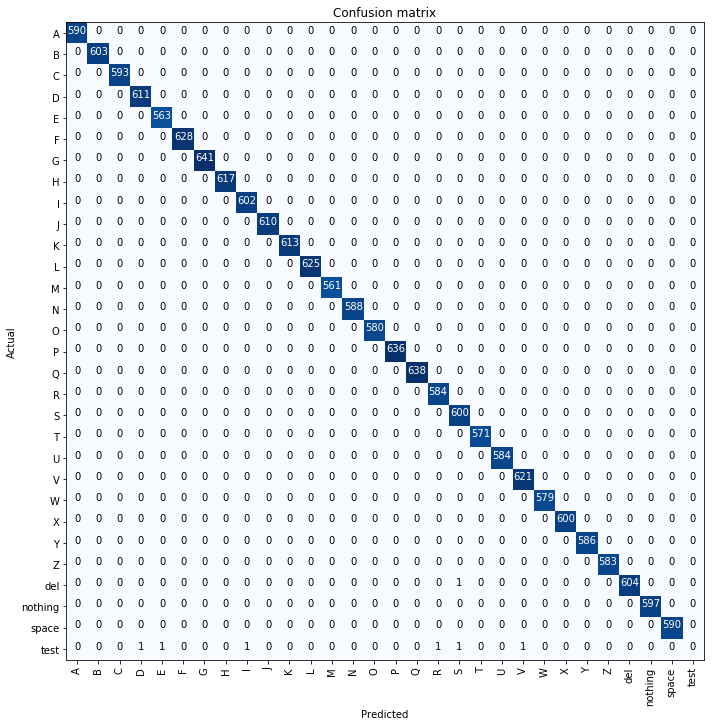

In [30]:
confusion_matrix((10,10))

torch.Size([3, 200, 200])


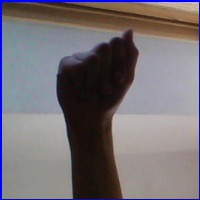

In [47]:
img = open_image(f'{path}/train/A/A1.jpg')
print(img.shape)
img

In [48]:
pred,_,_ = learn.predict(img)
pred

Category A

torch.Size([3, 200, 200])


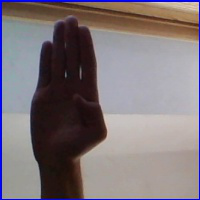

In [49]:
fnames = get_image_files(train_path+'B')
img = open_image(fnames[0])
print(img.shape)
img

In [50]:
fnames = get_image_files(train_path+'B')
img = open_image(fnames[0])
print(img.shape)
img

Category B

torch.Size([3, 200, 200])


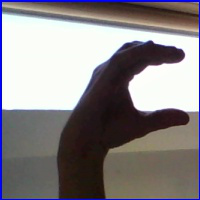

In [53]:
fnames = get_image_files(train_path+'C')
img = open_image(fnames[0])
print(img.shape)
img


In [54]:
pred,_,_ = learn.predict(img)
pred

Category C

torch.Size([3, 200, 200])


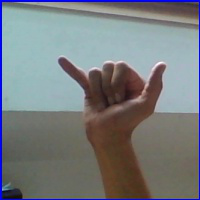

In [151]:
fnames = get_image_files(train_path+'Y')
img = open_image(fnames[10])
print(img.shape)
img



In [57]:
pred,_,_ = learn.predict(img)
pred

Category D

torch.Size([3, 250, 250])


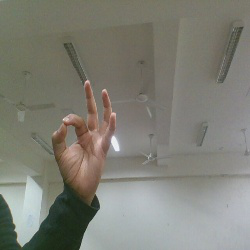

In [148]:

img = open_image('../data/f1.jpg')
print(img.shape)
img



In [149]:
pred,_,_ = learn.predict(img)
pred

Category X

In [147]:
import cv2
img = cv2.imread('../data/f.jpg')
img = cv2.resize(img,(250,250))
cv2.imwrite('../data/f1.jpg',img)


True

'D'